## Exploratory Analysis of Chicago crime data
Data source: https://console.cloud.google.com/marketplace/product/city-of-chicago-public-data/chicago-crime
I am connecting to the datasource via google big query using my work account as couldn't access directly via personal google account. 


## Deciding which data to import



This is a very large dataset with 7.5million rows and 22 columns, so not feasible to import the entire dataset into a python notebook, I am going to aggregate the data to an hourly level. 
Before aggregating the data, I want to check for nulls and duplicates

# Checking the data for nulls and duplicates. 

I checked for duplicates across the entire data set. 

select unique_key, count(*) 
FROM `bigquery-public-data.chicago_crime.crime`
group by unique_key
having count(*)>1

This returned 0, so there a no duplicates in the data over all columns,which means the unique_key is infact unique,  

However, I then wanted to check if there were any duplicates of the case number. 

I used the following SQL query. 

SELECT case_number, count(case_number) as count_case_number
FROM `bigquery-public-data.chicago_crime.crime`
group by case_number
having count(case_number)>1

This return 402 records, where a case number had more than one entry. I wanted to check if there was a theme to the duplicate case numbers, are their multiple crimes being recorded under the same case number, or are these duplicates that need to be removed. 

I had a quick look at the data table visually to see what the likely cause was. 

I used the following SQL query. 

with duplicate_case as (
SELECT case_number
FROM `bigquery-public-data.chicago_crime.crime`
group by case_number
having count(case_number)>1
)


select * from `bigquery-public-data.chicago_crime.crime` ds
inner join duplicate_case dc on ds.case_number = dc.case_number
order by ds.case_number

It looked like mostly duplicates, not the same case_number being used for multiple crimes, with the exception of when the case_number was null. 
It looked as though they were duplicates, with columns such as the date or time entered were slightly different. In the interest of time, I am going to assume they are duplicates that can be removed

# Aggregating the data to a manageable size for EDA.

I am going to aggregate over distinct case_number, which will remove any duplicates being counted, and in the interest of tume going to drop the null cases_numbers as there are only 4.  

Columns of data I am not going to use for the EDA. 

block, beat, district, ward, community_area, fbi_code

I am going to leave these columns out of any analysis, as these are all locational datapoints and without context these are not meaningful so wont be exploring further. 

IUCR and description, are more detail than I have time to look at for the type of offence, as will use the primary_type to explore the different types of crimes. 


# Some questions to explore in the data 
I explored the data initially in Google Data studio to become more familiar with the data and to help construct some questions that I was interested in asking. This was to ensure I wasn't missing anything from the raw dataset that I wanted to explore.  

1. Crime over the past 20 years - historical timeseries analysis to a monthly granularity
2. Types of crime commited over time. How has this changed?
3. What type of crime is more likely to lead to arrest?
4. How many crimes happen on average daily. 
5. What trends do we see in domestic crime, is this more likely to occur at certain times of day/day of week compared to other crimes? (ran out of time for this)

With further time, it would be interesting to explore the locational aspects of the data using geospatial data tools. 

## Load packages and load and prepare data

In [342]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from math import ceil, floor
from scipy import stats
from datetime import datetime as dt
from google.cloud import bigquery

In [341]:
# SQL query aggregating distinct case numbers over the hour, primary_type, arrest and domestic columns. 
# I have dropped any data in 2021, as we don't have a full years worth of data to avoid skewing conclusions, to allow time to input etc. 
HISTORICAL_DATA_QUERY = (
    """SELECT date_trunc(date, hour) date_hour, year, primary_type, arrest, domestic,
count(distinct case_number) as count_crime FROM `bigquery-public-data.chicago_crime.crime`
where date < '2021-01-01'
group by date_hour, year, primary_type, arrest, domestic 
order by date_hour, year, primary_type, arrest, domestic 
"""
)


In [343]:
#Define a function that will query the SQL from Bigquery and return in a pandas dataframe

def bq_query(
    query:str
) -> pd.DataFrame:

    bqclient = bigquery.Client()

# Download query results.
    query_string = query

    dataframe = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            create_bqstorage_client=True,
        )
    )

    df = pd.DataFrame(dataframe)
    return df

In [344]:
df_hist = bq_query(HISTORICAL_DATA_QUERY)   


/Users/samantha/.local/share/virtualenvs/211220_chicago_crime-iCr14a8e/lib/python3.9/site-packages/google/auth/_default.py:73: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/samantha/.local/share/virtualenvs/211220_chicago_crime-iCr14a8e/lib/python3.9/site-packages/google/auth/_default.py:73: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota 

In [349]:
# Add some date columns: month year and date
df_hist['month_year'] = df_hist['date_hour'].values.astype('datetime64[M]')
df_hist['date'] = df_hist['date_hour'].values.astype('datetime64[D]')
df_hist['hour'] = df_hist['date_hour'].dt.hour

In [348]:
#Size of the dataset is still quite large in terms of rows,  but dropping from 22 to 6 columns has made the query more manageable. 

#Print the size of the dataset
print("Historical info dataset number rows: {}".format(df_hist.shape[0]))


Historical info dataset number rows: 2005906


In [347]:
#Print the columns and dtypes for each dataset
print("Historical info column dtypes")
print(df_hist.dtypes)

df_hist['primary_type'] = df_hist['primary_type'].astype("category")


Historical info column dtypes
date_hour       datetime64[ns, UTC]
year                          int64
primary_type                 object
arrest                         bool
domestic                       bool
count_crime                   int64
dtype: object


In [335]:
#Check for duplicates (this would indicate an error). None expected due to the pre-aggreagation of data in SQL. 
print("Historical info duplicate rows: {}".format(len(df_hist)-len(df_hist.drop_duplicates())))

Historical info duplicate rows: 0


In [334]:
#Define some useful functions for plotting the data

def histplot(data, x, hue, binwidth):
    plt.figure(figsize = (22, 10))
    sns.set_style(style='whitegrid')
    sns.histplot(data=data,x=x, hue=hue, binwidth = binwidth, multiple='stack')

In [333]:
# Define line plot for use later
def lineplot(data, x=None, y=None):
    plt.figure(figsize = (22, 10))
    sns.set_style(style='whitegrid')
    sns.lineplot(data=data,x=x, y=y)

In [332]:
def barplot(x, y, data):
    plt.figure(figsize = (22, 10))
    sns.set_theme(style="whitegrid")
    sns.barplot(x=x, y=y, data=data)

In [331]:
# Define a kde plot funtion for use later
def kdeplot(data, x, hue, clip):
    plt.figure(figsize = (22, 10))
    sns.set_style(style='whitegrid')
    sns.kdeplot(data=data,x=x, hue=hue, clip=clip)

In [330]:
# Define a box plot funtion for use later

def boxplot(data, x, y=None):
    plt.figure(figsize = (22, 10))
    sns.set_style(style='whitegrid')
    sns.boxplot(data=data,x=x, y=y)

# 1. How has crime rates changed over time?

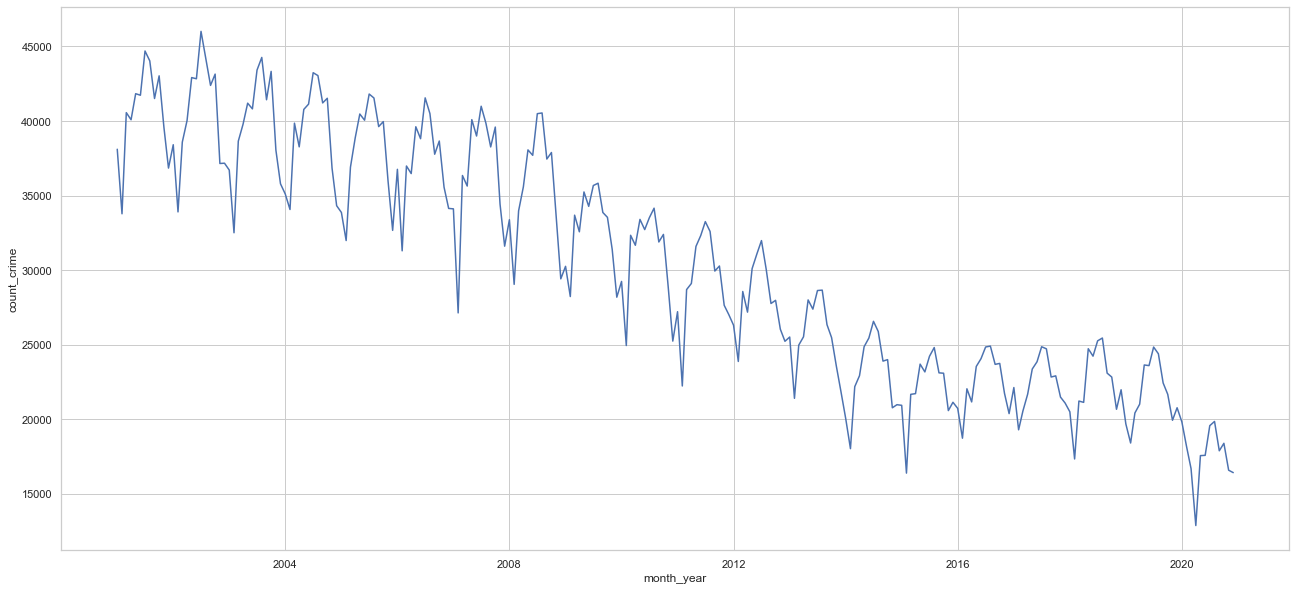

In [329]:
df_hist_1 = df_hist[['month_year','count_crime']].groupby(by='month_year',as_index=False).sum()
lineplot(data=df_hist_1,x=df_hist_1['month_year'],y=df_hist_1['count_crime'])

### Conclusions that we can draw from this chart:

- We can see from this chart that reported crime has dropped over the years. 
- There is a seasonal component to crime, with a dip occuring each year over the winter/holiday period.

Further work: Explore seasonal, time of day, day of week variations is crime and crime type. 




# 2. Types of crime commited over time. How has this changed?

year
2020   -0.339524
Name: THEFT, dtype: float64
year
2020   -0.584426
Name: THEFT, dtype: float64


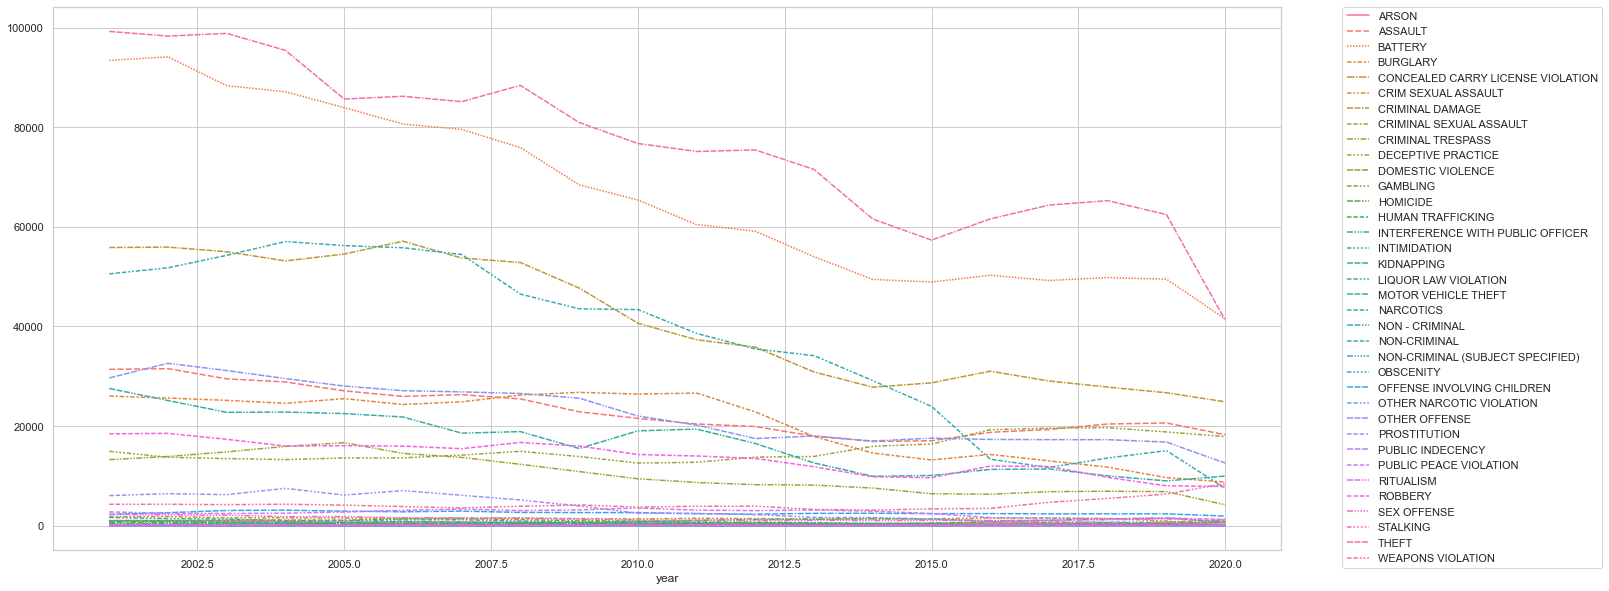

In [369]:
df_hist_2 = df_hist[['year','primary_type','count_crime']].groupby(['year','primary_type'],as_index=False)['count_crime'].sum()
df_hist_2_wide = df_hist_2.pivot(index='year',columns='primary_type',values='count_crime')

annual_change = df_hist_2_wide.pct_change()
overall_change  = df_hist_2_wide.loc[[2001,2020]].pct_change()
#print(annual_change)
#print(annual_change)

#overall_change = overall_change.pivot

lineplot(data=df_hist_2_wide)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print(annual_change.loc[[2020],'THEFT'])
print(overall_change.loc[[2020],'THEFT'])



### Conclusions that we can draw from this chart:

There are 4 types of crime that are more frequent than others, as it is difficult to see all of the colours on the above chart, want to check which lines are the top 4 crimes. 
Theft saw the greatest drop in report crime numbers from 2001 to 2020, down 58%
Theft also saw a sharp decline from 2019 to 2020 - down 33%

In [345]:
df_hist_2a = df_hist[['primary_type','count_crime']].groupby('primary_type').sum()
df_hist_2a_sorted = df_hist_2a.sort_values('count_crime',ascending = False).head(4)
print(df_hist_2a_sorted)

                 count_crime
primary_type                
THEFT                1531225
BATTERY              1329450
CRIMINAL DAMAGE       826554
NARCOTICS             736054


The top 4 crimes are theft, battery (defined as threatening behavior), criminal damage and narcotics. 

# 3. What type of crime is more likely to lead to arrest. 

In [350]:
df_hist_3 = df_hist[['primary_type','arrest','count_crime']].groupby(['primary_type','arrest'],as_index=False)['count_crime'].sum()
df_hist_3_wide = df_hist_3.pivot(index='primary_type',columns='arrest',values='count_crime')


df_hist_3_wide['pct_arrest'] = df_hist_3_wide[True]/(df_hist_3_wide[True]+df_hist_3_wide[False])


df_hist_3_sorted = df_hist_3_wide.sort_values(by='pct_arrest',ascending=False, na_position='last').reset_index()
df_hist_3_sorted_above_20 = df_hist_3_sorted.drop(df_hist_3_sorted[df_hist_3_sorted.pct_arrest < 0.2].index)
print(df_hist_3_sorted_above_20)


#barplot(x='primary_type',y= 'pct_arrest',data=df_hist_3_sorted_above_20)

arrest                       primary_type    False    True  pct_arrest
0                       DOMESTIC VIOLENCE        0       1    1.000000
1                            PROSTITUTION      268   69103    0.996137
2                        PUBLIC INDECENCY        1     183    0.994565
3                               NARCOTICS     4170  731884    0.994335
4                                GAMBLING      104   14490    0.992874
5                    LIQUOR LAW VIOLATION      124   14335    0.991424
6       CONCEALED CARRY LICENSE VIOLATION       22     647    0.967115
7        INTERFERENCE WITH PUBLIC OFFICER     1369   16130    0.921767
8                               OBSCENITY      136     570    0.807365
9                       WEAPONS VIOLATION    19747   66408    0.770797
10                      CRIMINAL TRESPASS    57624  147610    0.719228
11               OTHER NARCOTIC VIOLATION       41      97    0.702899
12                 PUBLIC PEACE VIOLATION    18433   32339    0.636946
13    

### Conclusions that we can draw from this data:

Here we can see that all crimes categorised as domestic violence lead to arrest, however there is only one datapoint. The next on the list, prositution has a 99.6% chance of arrest, and as there is a reasonable amount of data.

With further time - it would be good to be able to bootstrap the data - to enable confidence intervals to be calculated. 



# 4. How many crimes happen on a daily basis/what time of day do they occur?



994.145106091718
973.0


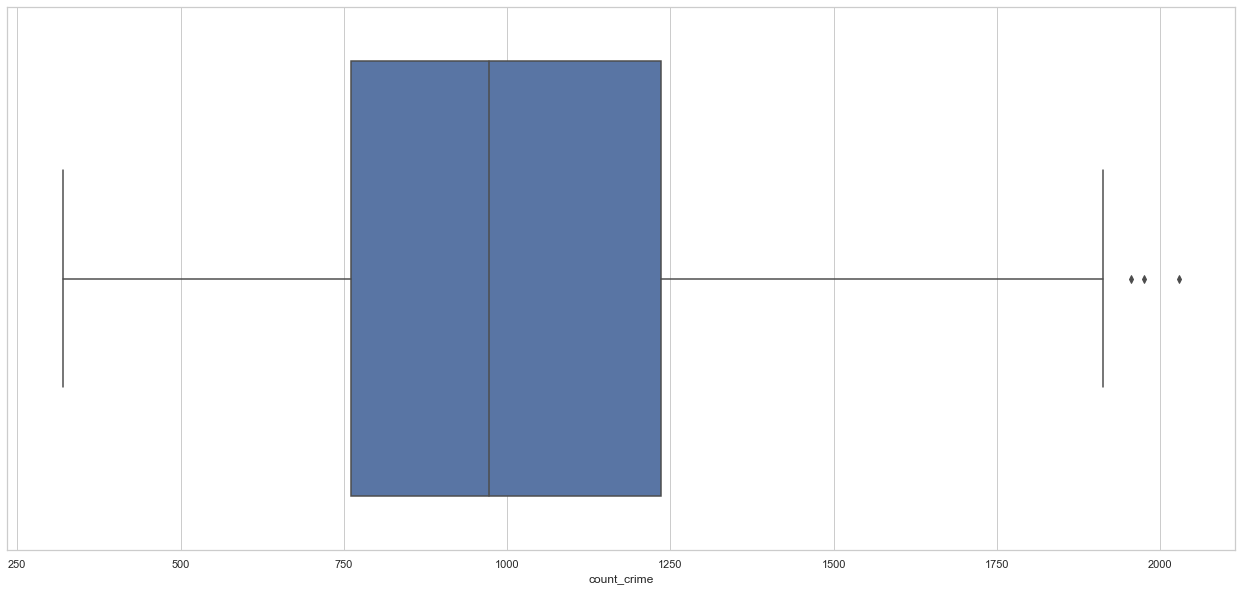

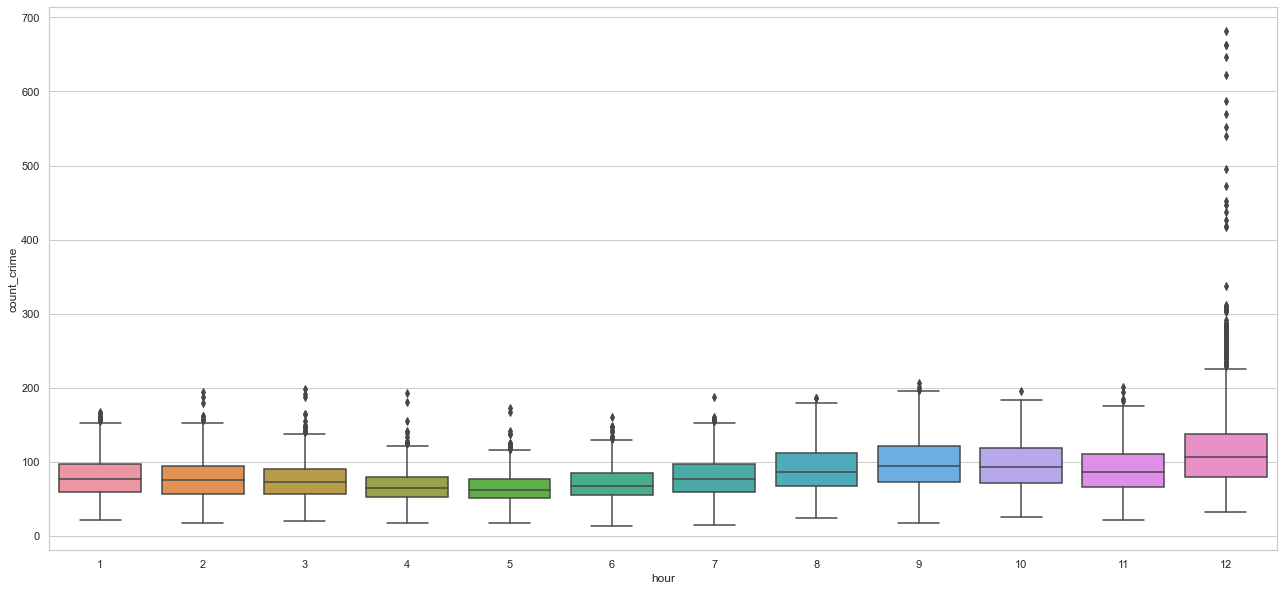

In [351]:
df_hist_4 = df_hist[['date','count_crime']].groupby(['date'],as_index=False)['count_crime'].sum()
df_hist_4_mean = df_hist_4['count_crime'].mean()
df_hist_4_median = df_hist_4['count_crime'].median()
boxplot(data=df_hist_4,x='count_crime')
print(df_hist_4_mean)
print(df_hist_4_median)
df_hist_4b = df_hist[['date','hour','count_crime']].groupby(['date','hour'],as_index=False)['count_crime'].sum()

boxplot(data=df_hist_4b,x='hour',y='count_crime')


### Conclusions that we can draw from these charts:

On average 994 crimes occur each day. The mean is higher than the median of 973, so the data is positevely skewed. Which you can also see from the whiskers of the box plot. 


The second chart with the time of crimes occurring throughout the day has lead me to discover that the date column of the data set is not formatted correctly, as there is not datapoints with a time in the between 12pm and 12am (afternoon). Need to look into this furthur and therefore can't draw any conclusions from this chart. 



# What trends do we see with domestic crime? Does it occur at certain times of day, day of week.

domestic   False   True
year                   
2001      427094  58714
2002      425565  61200
2003      422109  53836
2004      414911  54492
2005      403001  50753


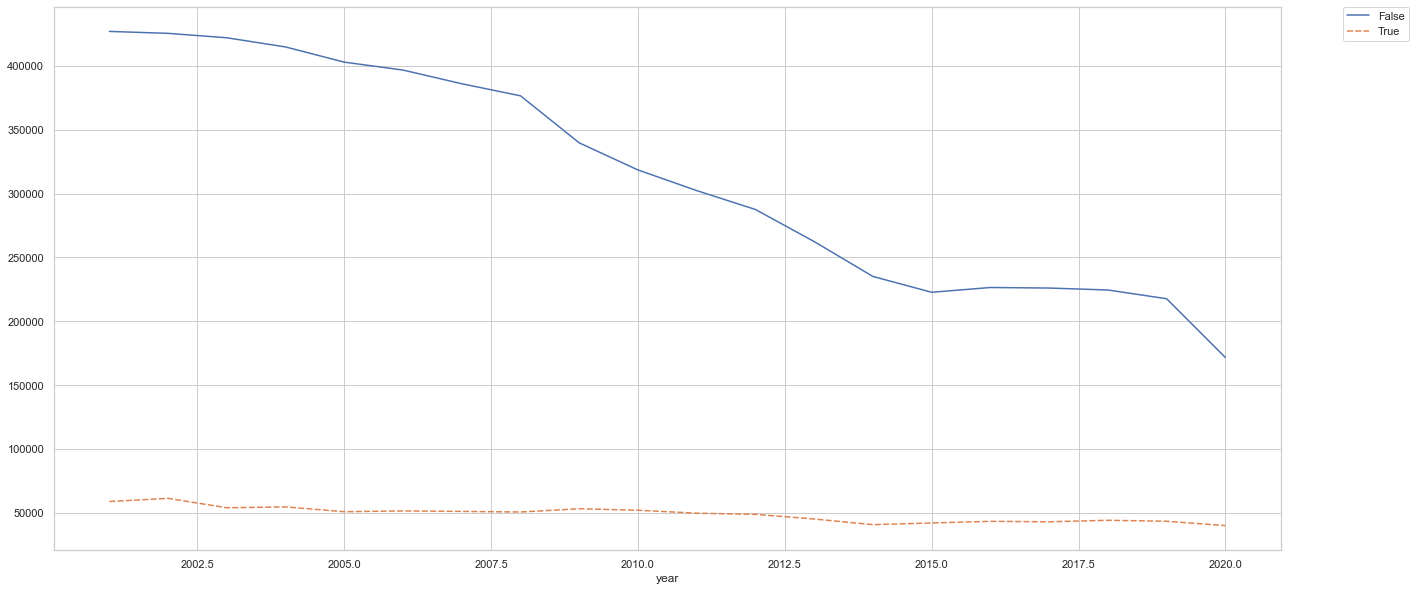

In [312]:
df_hist_5 = df_hist[['year','domestic','count_crime']].groupby(['year','domestic'],as_index=False)['count_crime'].sum()
df_hist_5_wide = df_hist_5.pivot(index='year',columns='domestic',values='count_crime')
print(df_hist_5_wide.head())



lineplot(data=df_hist_5_wide)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Conclusions that we can draw from this chart:


This chart shows that domestic crime reported in Chicago has not dropped with crime rates overall. This would be an interesting trend to look into with further time - and would be interested to explore what time of day domestic crimes occur, but with the datetime data issues this was not possible. 